## The Stokes flow (calculation of effective permeability)
#### (1.1) The governing equation 
The governing PDE is
\begin{equation}
\begin{split}
 -\mu\nabla^2{\bf u} + \nabla p &={\bf 0}, \quad \text{in}\ \Omega \\
   \nabla\cdot {\bf u} &= 0,\quad \text{in}\ \Omega
\end{split}
\end{equation}
where $p(N/m^2)$ is the pressure, ${\bf u} (m/s)$ is the velocity vector, ${\bf f}$ is the applied body force, $\mu$ is the dynamic viscosity.
A typical set of boundary conditions on the boundary $\partial\Omega = \Gamma_D\cup \Gamma_N$ can be:
\begin{equation}
\begin{split}
 {\bf u} = {\bf u}_0, \quad \text{on}\ \Gamma_D \\
(\nabla\cdot{\bf u}+p)\cdot\vec{n} = g\quad \text{on}\ \Gamma_N
\end{split}
\end{equation}
#### (1.2) The continuum and constitutive formulations
\begin{equation}
\begin{split}
- \nabla\cdot {\bf \sigma}  &= {\bf f}, \quad \text{in}\ \Omega \\
   \nabla\cdot {\bf u} &= 0,\quad \text{in}\ \Omega 
\end{split}
\end{equation}
where 
\begin{equation}
{\bf \sigma} = -p{\bf I} + \mu(\nabla{\bf u}+\nabla{\bf u}^T) 
\end{equation}
is the Cauchy stress tensor, and $p=-tr({\bf \sigma})/2$.
#### (1.3) The weak form
\begin{equation}
\begin{split}
\int {\bf \sigma} \cdot\nabla^T\psi ~dx =  \int {\bf f}\psi~dx
\end{split}
\end{equation}
where 
\begin{equation}
{\bf \sigma} = -p{\bf I} + \mu(\nabla{\bf u}+\nabla{\bf u}^T) ,
\end{equation}
and $p=-tr({\bf \sigma})/2$.
#### (1.4) The problem
The domain is given in the following figure and the initial/boundary conditions are given as:
- **In flow:** ${\bf u}=(4y(1-y), 0)$
- **Out flow:** $p=0$
- **non-slip wall:** ${\bf u}={\bf 0}$
- **Cylinder:** ${\bf u=0}$
  
For the parameters in the equation, we set  $\mu=0.01$.

#### (1.5) 
\begin{equation}
\begin{split} 
 - \mu
\left[
\begin{matrix}
u_{xx}+u_{yy}\\
v_{xx}+v_{yy}
\end{matrix}
\right] +
\left[
\begin{matrix}
p_x \\
p_y
\end{matrix}
\right]
= 
\left[
\begin{matrix}
f_1 \\
f_2
\end{matrix}
\right]
\end{split}
\end{equation}
The corresponding weak form is
\begin{equation}
\begin{split}
\mu\int\nabla u\cdot\nabla\psi_1~d\Omega - \int p\frac{\partial \psi_1}{\partial x} ~d\Omega &= \int f_1\psi_1~d\Omega \\
\mu\int\nabla v\cdot\nabla\psi_2~d\Omega - \int p\frac{\partial \psi_2}{\partial y} ~d\Omega &= \int f_2\psi_2~d\Omega 
\end{split}
\end{equation}
#### (1.6)
\begin{equation}
\begin{split}
-
\left[
\begin{matrix}
\frac{\partial \sigma_{11}}{\partial x} + \frac{\partial \sigma_{21}}{\partial y}  \\
\frac{\partial \sigma_{12}}{\partial x} + \frac{\partial \sigma_{22}}{\partial y}
\end{matrix}
\right] =
\left[
\begin{matrix}
f_1 \\
f_2
\end{matrix}
\right]
\end{split}
\end{equation}
The corresponding weak form is
\begin{equation}
\begin{split}
\int (\sigma_{11}\frac{\partial \psi_1}{\partial x}+\sigma_{21}\frac{\partial \psi_1}{\partial y})~d\Omega &= \int f_1\psi_1~d\Omega \\
\int (\sigma_{12}\frac{\partial \psi_2}{\partial x}+\sigma_{22}\frac{\partial \psi_2}{\partial y})~d\Omega  &= \int f_2\psi_2~d\Omega 
\end{split}
\end{equation}

### (1) The ParticleWNN method

dict_keys(['__header__', '__version__', '__globals__', 'x', 'u', 'v', 'p', 'dpx', 'dpy'])


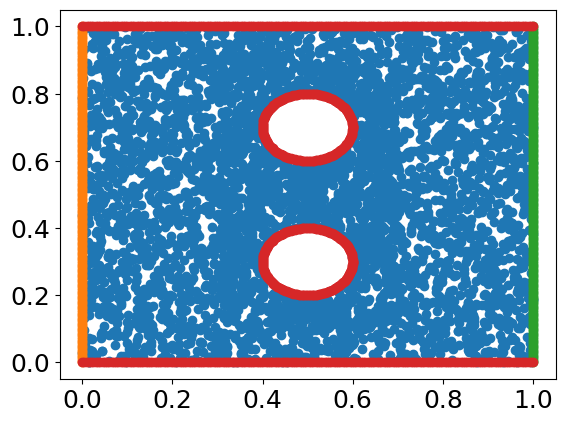

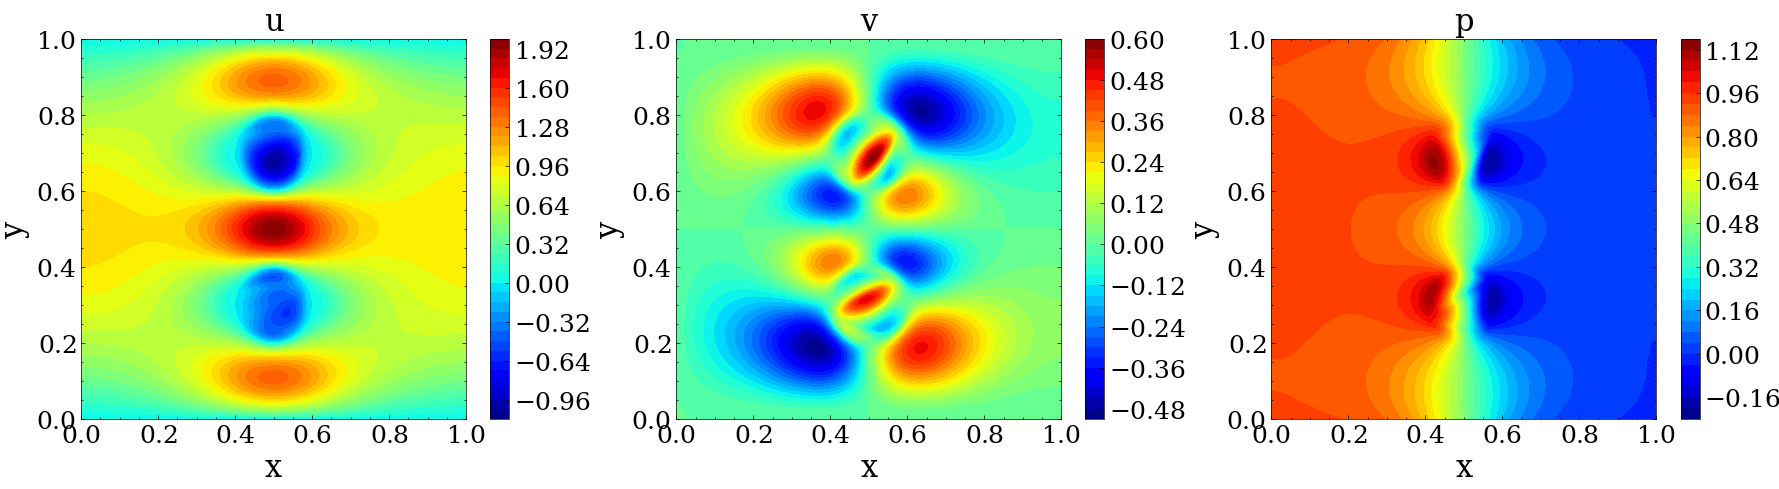

In [1]:
import sys 
sys.path.append("../..") 
#
import numpy as np
import h5py
import torch
import scipy.io
from Utils.GenPoints import Point2D
from Utils.PlotFigure import Plot
import matplotlib.pyplot as plt
#
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
random_seed = 1232
device = 'cuda:0'
dtype = torch.float32
setup_seed(random_seed)
problem_name = 'Stokes_hole'
####################################
# Load data
####################################
try:
    data = h5py.File('../../Problems/Stokes/truth_stokes_hole.mat', 'r')
except:
    data = scipy.io.loadmat('../../Problems/Stokes/truth_stokes_hole.mat')
print(data.keys())
u_test, v_test, x_test = np.array(data['u']), np.array(data['v']), np.array(data['x'])
p_test, dpx_test = np.array(data['p']), np.array(data['dpx'])
u_test = torch.tensor(u_test.reshape(-1,1), dtype=dtype)
v_test = torch.tensor(v_test.reshape(-1,1), dtype=dtype)
p_test = torch.tensor(p_test.reshape(-1,1), dtype=dtype)
dpx_test = torch.tensor(dpx_test.reshape(-1,1), dtype=dtype)
x_test = torch.tensor(x_test, dtype=dtype)
######################################
# Setups of the problem 
######################################
N_in, N_refine, N_bd_each_edge = 4000, 1000, 200
#
pointGen = Point2D(x_lb=[0., 0.], x_ub=[1., 1.], dataType=dtype, random_seed=random_seed)
refineGen = Point2D(x_lb=[0.3, 0.1], x_ub=[0.7, 0.9], dataType=dtype, random_seed=random_seed)
# The inner points
x_in = pointGen.inner_point(num_sample_or_mesh=N_in, method='hypercube')
x_in_refine = refineGen.inner_point(num_sample_or_mesh=N_refine, method='hypercube')
x_in_train = torch.cat((x_in, x_in_refine), axis=0)
index_1 = torch.where(torch.linalg.norm(x_in_train-torch.tensor([0.5,0.3]), axis=1, keepdims=True)<=0.1+1e-4)[0]
index_2 = torch.where(torch.linalg.norm(x_in_train-torch.tensor([0.5,0.7]), axis=1, keepdims=True)<=0.1+1e-4)[0]
index = [i for i in range(x_in_train.shape[0]) if i not in index_1 and i not in index_2]
x_in_train = x_in_train[index,:]
# The boundary points
x_bd_train = pointGen.boundary_point(num_each_edge=N_bd_each_edge, method='mesh')
#
x_lt = x_bd_train[0:N_bd_each_edge]
x_rt = x_bd_train[N_bd_each_edge:2*N_bd_each_edge]
x_bt = x_bd_train[2*N_bd_each_edge:3*N_bd_each_edge]
x_up = x_bd_train[3*N_bd_each_edge:]
x_cld1 = pointGen.boundary_point_sphere(N_bd_each_edge, xc=[0.5,0.3], radius=0.1, method='mesh')
x_cld2 = pointGen.boundary_point_sphere(N_bd_each_edge, xc=[0.5,0.7], radius=0.1, method='mesh')
x_cld = torch.cat((x_cld1, x_cld2), axis=0)
###########################################
x_inflow = x_lt
x_outflow = x_rt
x_wall = torch.cat((x_up, x_bt, x_cld), axis=0)
############################################
plt.figure()
plt.scatter(x_in_train[:,0], x_in_train[:,1])
plt.scatter(x_inflow[:,0], x_inflow[:,1])
plt.scatter(x_outflow[:,0], x_outflow[:,1])
plt.scatter(x_wall[:,0], x_wall[:,1])
# plt.scatter(xc_init[:,0], xc_init[:,1])
plt.show()
#######################################
Plot.show_2d_list(x_test, [u_test, v_test, p_test],['u', 'v', 'p'], ub=[1., 1.])

### (2) Define the loss class

In [2]:
from torch.autograd import grad, Variable
from Utils.GenPoints import Point2D
from Utils.TestFun_ParticleWNN import TestFun_ParticleWNN

#####################################
int_grid, phi, dphi_dr = TestFun_ParticleWNN(
    fun_type='Wendland', dim=2, n_mesh_or_grid=7, 
    dataType=dtype).get_testFun()
#
xc_train = x_in_train.reshape(-1, 1, 2)
_, R_train = pointGen.weight_centers(n_center=xc_train.shape[0], R_max=1e-4, R_min=1e-4)

######################################
def fun_u_inflow(x):
    return 4.*x[...,1:2]*(1.-x[...,1:2])
#
u_inflow_true = fun_u_inflow(x_inflow)
    
class LossClass(object):

    def __init__(self, solver):
        super(LossClass, self).__init__()
        '''
        '''
        self.solver = solver
        self.device = self.solver.device
        self.dtype = self.solver.dtype
        self.model_psip = solver.model_dict['psi_p']
        ######################## 
        self.int_grid = int_grid.to(self.device)
        self.n_grid = int_grid.shape[0]
        self.phi = phi.to(self.device)
        self.dphi_dr = dphi_dr.to(self.device)
        #
        self.solver.getLoss = torch.nn.MSELoss()

    def get_values(self, x_device):
        '''
        '''
        psi_p = self.model_psip(x_device)
        psi, p = psi_p[...,0:1], psi_p[...,1:2]
        #
        dpsi = self.solver.grad(psi, [x_device])[0]
        u, v = dpsi[...,1:2], - dpsi[...,0:1]
        #
        s11, s22, s12 = psi_p[...,2:3], psi_p[...,3:4], psi_p[...,4:5]
        
        return u, v, p, s11, s22, s12

    def Loss_pde(self, xc=None, R=None, mu=0.01):
        '''
        Input:
            x_in: size(n_batch, dx)
        '''
        xc, R = xc.to(self.device), R.to(self.device)
        nc = xc.shape[0]
        ################################## 
        x = self.int_grid * R + xc
        x = Variable(x.reshape(-1, 2), requires_grad=True)
        ################################## The test functions
        phi = self.phi.repeat((nc,1,1)).reshape(-1,1)
        dphi = (self.dphi_dr / R).reshape(-1, 2)
        ################################## The predicted values
        u, v, p, s11, s22, s12 = self.get_values(x)
        #
        du = self.solver.grad(u, [x])[0]
        dv = self.solver.grad(v, [x])[0]
        ########################### Eq_1 & Eq_2
        res1 = (s11*dphi[...,0:1] + s12*dphi[...,1:2])
        res1 = torch.mean(res1.reshape(nc, self.n_grid), dim=-1, keepdim=True)
        #
        res2 = (s12*dphi[...,0:1] + s22*dphi[...,1:2])
        res2 = torch.mean(res2.reshape(nc, self.n_grid), dim=-1, keepdim=True)
        ########################### Eq_3 & Eq_4
        res3 = -p + 2*mu*du[...,0:1] - s11
        res4 = -p + 2*mu*dv[...,1:2] - s22
        res5 = mu*(du[...,1:2]+dv[...,0:1]) - s12
        ########################### Eq6
        res6 = p + (s11+s22)/2
        ###############################
        loss = (self.solver.getLoss(res1, torch.zeros_like(res1)) + 
                self.solver.getLoss(res2, torch.zeros_like(res2)) +
                self.solver.getLoss(res3, torch.zeros_like(res3)) +
                self.solver.getLoss(res4, torch.zeros_like(res4)) +
                self.solver.getLoss(res5, torch.zeros_like(res5)) +
                self.solver.getLoss(res6, torch.zeros_like(res6)) 
               )
        
        return loss * 10.

    def Loss_bd(self):
        loss = 0.
        ######################### The wall
        xwall = Variable(x_wall, requires_grad=True).to(self.device)
        u_wall, v_wall, _, _, _, _ = self.get_values(xwall)
        #
        loss += self.solver.getLoss(u_wall, torch.zeros_like(u_wall)) 
        loss += self.solver.getLoss(v_wall, torch.zeros_like(v_wall))
        ######################### The inflow 
        xinflow = Variable(x_inflow, requires_grad=True).to(self.device)
        u_inflow, v_inflow, _, _, _, _ = self.get_values(xinflow)
        #
        loss += self.solver.getLoss(u_inflow, u_inflow_true.to(self.device)) 
        loss += self.solver.getLoss(v_inflow, torch.zeros_like(v_inflow))
        ######################### The outflow 
        xoutflow = Variable(x_outflow, requires_grad=True).to(self.device)
        _, _, p_outflow, _, _, _ = self.get_values(xoutflow)
        loss += self.solver.getLoss(p_outflow, torch.zeros_like(p_outflow))
        
        return loss * 2.
        
    def Error(self):
        '''
        Input:
            x_in_test: size(n_test, dx)
        '''
        x = Variable(x_test, requires_grad=True).to(self.device)
        u_pred, v_pred, p_pred, _, _, _ = self.get_values(x)
        #########
        error_u = self.solver.getError(u_pred, u_test.to(self.device))
        error_v = self.solver.getError(v_pred, v_test.to(self.device))
        #########
        error = [error_u, error_v]
        
        return error

# #####################################
# # Define the model
# #####################################
from Solvers.ParticleWNN import ParticleWNN
solver = ParticleWNN.Solver(device, dtype=dtype)
#
psi_p_model = solver.getModel(layers_list=[2]+[40]*8+[5], activation='Tanh', netType='FCNet')

### (3) Training make prediction

#### (3.1) Train the model

In [3]:
model_dict = {'psi_p': psi_p_model}
solver.train_setup(model_dict, lr=1e-3, optimizer='Adam', scheduler_type=None, lbfgs=True, max_iter=5000)
solver.train(LossClass, xc_train, R_train, batch_size_in=int(np.ceil(xc_train.shape[0]/5)), epochs=10000, 
             **{'save_path':f'saved_models/'})
solver.train_lbfgs(LossClass, xc_train, R_train, epochs=200, **{'save_path':f'saved_models/'})

  1%|▊                                                                             | 102/10000 [00:11<15:38, 10.55it/s]

Epoch:100 Time:11.0642, loss_in:0.002687, loss_bd:0.158769
          lr: 0.001 l2_err [0.7237182855606079, 1.2956604957580566]


  2%|█▌                                                                            | 202/10000 [00:20<15:08, 10.78it/s]

Epoch:200 Time:20.4630, loss_in:0.029518, loss_bd:0.085248
          lr: 0.001 l2_err [0.6727815270423889, 1.4484893083572388]


  3%|██▎                                                                           | 302/10000 [00:29<15:24, 10.49it/s]

Epoch:300 Time:29.8117, loss_in:0.032467, loss_bd:0.075171
          lr: 0.001 l2_err [0.6618673801422119, 1.4828696250915527]


  4%|███▏                                                                          | 401/10000 [00:40<17:24,  9.19it/s]

Epoch:400 Time:39.9711, loss_in:0.032520, loss_bd:0.072968
          lr: 0.001 l2_err [0.6628506779670715, 1.5093581676483154]


  5%|███▉                                                                          | 502/10000 [00:49<14:32, 10.89it/s]

Epoch:500 Time:49.4370, loss_in:0.032298, loss_bd:0.071738
          lr: 0.001 l2_err [0.6605265736579895, 1.4782893657684326]


  6%|████▋                                                                         | 602/10000 [00:58<14:37, 10.71it/s]

Epoch:600 Time:58.7510, loss_in:0.031737, loss_bd:0.064126
          lr: 0.001 l2_err [0.6294155716896057, 1.4235471487045288]


  7%|█████▍                                                                        | 702/10000 [01:08<14:26, 10.73it/s]

Epoch:700 Time:68.0697, loss_in:0.034907, loss_bd:0.047008
          lr: 0.001 l2_err [0.5463529229164124, 1.1464459896087646]


  8%|██████▎                                                                       | 802/10000 [01:17<14:26, 10.62it/s]

Epoch:800 Time:77.4134, loss_in:0.035046, loss_bd:0.044458
          lr: 0.001 l2_err [0.5368619561195374, 1.1409482955932617]


  9%|███████                                                                       | 901/10000 [01:30<21:03,  7.20it/s]

Epoch:900 Time:90.4340, loss_in:0.035266, loss_bd:0.042808
          lr: 0.001 l2_err [0.5268653035163879, 1.1414071321487427]


 10%|███████▋                                                                     | 1001/10000 [01:44<20:45,  7.23it/s]

Epoch:1000 Time:104.4614, loss_in:0.034266, loss_bd:0.041161
          lr: 0.001 l2_err [0.512240469455719, 1.126621961593628]


 11%|████████▍                                                                    | 1101/10000 [01:58<20:37,  7.19it/s]

Epoch:1100 Time:118.3900, loss_in:0.032980, loss_bd:0.038133
          lr: 0.001 l2_err [0.46487894654273987, 1.020693063735962]


 12%|█████████▏                                                                   | 1201/10000 [02:12<20:29,  7.16it/s]

Epoch:1200 Time:132.4357, loss_in:0.032808, loss_bd:0.030403
          lr: 0.001 l2_err [0.35794198513031006, 0.8550248146057129]


 13%|██████████                                                                   | 1301/10000 [02:26<20:11,  7.18it/s]

Epoch:1300 Time:146.4048, loss_in:0.032722, loss_bd:0.027078
          lr: 0.001 l2_err [0.3575652241706848, 0.7914659380912781]


 14%|██████████▊                                                                  | 1401/10000 [02:40<22:00,  6.51it/s]

Epoch:1400 Time:160.3561, loss_in:0.031818, loss_bd:0.036089
          lr: 0.001 l2_err [0.3304283916950226, 0.7483240962028503]


 15%|███████████▌                                                                 | 1501/10000 [02:54<19:32,  7.25it/s]

Epoch:1500 Time:174.1844, loss_in:0.032000, loss_bd:0.024068
          lr: 0.001 l2_err [0.32133564352989197, 0.7447962760925293]


 16%|████████████▎                                                                | 1601/10000 [03:08<19:27,  7.20it/s]

Epoch:1600 Time:188.0307, loss_in:0.031386, loss_bd:0.020465
          lr: 0.001 l2_err [0.31648677587509155, 0.688606321811676]


 17%|█████████████                                                                | 1701/10000 [03:22<19:11,  7.21it/s]

Epoch:1700 Time:202.0105, loss_in:0.029767, loss_bd:0.016531
          lr: 0.001 l2_err [0.28836312890052795, 0.6425939798355103]


 18%|█████████████▊                                                               | 1801/10000 [03:36<19:09,  7.13it/s]

Epoch:1800 Time:216.0463, loss_in:0.029109, loss_bd:0.012793
          lr: 0.001 l2_err [0.25664305686950684, 0.5691578388214111]


 19%|██████████████▋                                                              | 1901/10000 [03:50<18:47,  7.18it/s]

Epoch:1900 Time:230.0124, loss_in:0.026748, loss_bd:0.013338
          lr: 0.001 l2_err [0.23829029500484467, 0.5359814167022705]


 20%|███████████████▍                                                             | 2001/10000 [04:04<18:43,  7.12it/s]

Epoch:2000 Time:244.0609, loss_in:0.025022, loss_bd:0.009739
          lr: 0.001 l2_err [0.2093360424041748, 0.4882838726043701]


 21%|████████████████▏                                                            | 2101/10000 [04:18<18:19,  7.18it/s]

Epoch:2100 Time:258.1981, loss_in:0.024167, loss_bd:0.008220
          lr: 0.001 l2_err [0.20115144550800323, 0.4351658523082733]


 22%|████████████████▉                                                            | 2201/10000 [04:32<18:09,  7.16it/s]

Epoch:2200 Time:272.1934, loss_in:0.026159, loss_bd:0.007477
          lr: 0.001 l2_err [0.178836852312088, 0.396104097366333]


 23%|█████████████████▋                                                           | 2301/10000 [04:46<19:24,  6.61it/s]

Epoch:2300 Time:286.3190, loss_in:0.022492, loss_bd:0.007931
          lr: 0.001 l2_err [0.1655133068561554, 0.3699347972869873]


 24%|██████████████████▍                                                          | 2401/10000 [05:00<18:14,  6.94it/s]

Epoch:2400 Time:300.3853, loss_in:0.020751, loss_bd:0.006712
          lr: 0.001 l2_err [0.1498519331216812, 0.3470866084098816]


 25%|███████████████████▎                                                         | 2501/10000 [05:14<17:35,  7.11it/s]

Epoch:2500 Time:314.4983, loss_in:0.019980, loss_bd:0.005645
          lr: 0.001 l2_err [0.1566157042980194, 0.3332756459712982]


 26%|████████████████████                                                         | 2601/10000 [05:28<17:15,  7.15it/s]

Epoch:2600 Time:328.8307, loss_in:0.020791, loss_bd:0.005110
          lr: 0.001 l2_err [0.13545970618724823, 0.31575432419776917]


 27%|████████████████████▊                                                        | 2701/10000 [05:43<16:59,  7.16it/s]

Epoch:2700 Time:342.9342, loss_in:0.018428, loss_bd:0.005117
          lr: 0.001 l2_err [0.14656664431095123, 0.3011889159679413]


 28%|█████████████████████▌                                                       | 2801/10000 [05:57<16:41,  7.19it/s]

Epoch:2800 Time:357.1091, loss_in:0.017857, loss_bd:0.004700
          lr: 0.001 l2_err [0.13502223789691925, 0.3002176582813263]


 29%|██████████████████████▎                                                      | 2901/10000 [06:11<16:25,  7.20it/s]

Epoch:2900 Time:371.1738, loss_in:0.018586, loss_bd:0.004806
          lr: 0.001 l2_err [0.13314956426620483, 0.282593309879303]


 30%|███████████████████████                                                      | 3001/10000 [06:25<16:22,  7.13it/s]

Epoch:3000 Time:385.3148, loss_in:0.017921, loss_bd:0.005837
          lr: 0.001 l2_err [0.13771578669548035, 0.27679944038391113]


 31%|███████████████████████▉                                                     | 3101/10000 [06:39<16:11,  7.10it/s]

Epoch:3100 Time:399.5065, loss_in:0.018191, loss_bd:0.004448
          lr: 0.001 l2_err [0.1223907470703125, 0.27920275926589966]


 32%|████████████████████████▋                                                    | 3201/10000 [06:53<15:44,  7.20it/s]

Epoch:3200 Time:413.7942, loss_in:0.018328, loss_bd:0.004432
          lr: 0.001 l2_err [0.12739504873752594, 0.28071391582489014]


 33%|█████████████████████████▍                                                   | 3301/10000 [07:08<15:47,  7.07it/s]

Epoch:3300 Time:427.9848, loss_in:0.015861, loss_bd:0.003548
          lr: 0.001 l2_err [0.11817881464958191, 0.25990140438079834]


 34%|██████████████████████████▏                                                  | 3401/10000 [07:22<15:26,  7.12it/s]

Epoch:3400 Time:442.0633, loss_in:0.016537, loss_bd:0.003609
          lr: 0.001 l2_err [0.11391819268465042, 0.26532691717147827]


 35%|██████████████████████████▉                                                  | 3501/10000 [07:36<15:05,  7.18it/s]

Epoch:3500 Time:456.2159, loss_in:0.015807, loss_bd:0.003638
          lr: 0.001 l2_err [0.11503749340772629, 0.25282058119773865]


 36%|███████████████████████████▋                                                 | 3601/10000 [07:50<14:58,  7.12it/s]

Epoch:3600 Time:470.3101, loss_in:0.015160, loss_bd:0.003086
          lr: 0.001 l2_err [0.10775309056043625, 0.243876114487648]


 37%|████████████████████████████▍                                                | 3701/10000 [08:04<15:26,  6.80it/s]

Epoch:3700 Time:484.4936, loss_in:0.014433, loss_bd:0.002967
          lr: 0.001 l2_err [0.10235454887151718, 0.23676541447639465]


 38%|█████████████████████████████▎                                               | 3801/10000 [08:18<14:37,  7.07it/s]

Epoch:3800 Time:498.5568, loss_in:0.014032, loss_bd:0.003592
          lr: 0.001 l2_err [0.11105413734912872, 0.23113220930099487]


 39%|██████████████████████████████                                               | 3901/10000 [08:32<15:41,  6.48it/s]

Epoch:3900 Time:512.4110, loss_in:0.014818, loss_bd:0.003420
          lr: 0.001 l2_err [0.09980830550193787, 0.22670480608940125]


 40%|██████████████████████████████▊                                              | 4002/10000 [08:42<09:16, 10.79it/s]

Epoch:4000 Time:522.7765, loss_in:0.013705, loss_bd:0.003473
          lr: 0.001 l2_err [0.09159338474273682, 0.2122514247894287]


 41%|███████████████████████████████▌                                             | 4102/10000 [08:52<08:59, 10.94it/s]

Epoch:4100 Time:531.9839, loss_in:0.012830, loss_bd:0.002955
          lr: 0.001 l2_err [0.09283159673213959, 0.2052113264799118]


 42%|████████████████████████████████▎                                            | 4202/10000 [09:01<08:52, 10.90it/s]

Epoch:4200 Time:541.3030, loss_in:0.011577, loss_bd:0.004119
          lr: 0.001 l2_err [0.07929950952529907, 0.18960453569889069]


 43%|█████████████████████████████████▏                                           | 4302/10000 [09:10<08:40, 10.95it/s]

Epoch:4300 Time:550.4596, loss_in:0.011128, loss_bd:0.002301
          lr: 0.001 l2_err [0.0860326737165451, 0.19467811286449432]


 44%|█████████████████████████████████▉                                           | 4402/10000 [09:19<08:28, 11.02it/s]

Epoch:4400 Time:559.6711, loss_in:0.011165, loss_bd:0.003272
          lr: 0.001 l2_err [0.07408025860786438, 0.17819491028785706]


 45%|██████████████████████████████████▋                                          | 4502/10000 [09:29<08:49, 10.39it/s]

Epoch:4500 Time:568.8829, loss_in:0.011065, loss_bd:0.003839
          lr: 0.001 l2_err [0.08097677677869797, 0.17692160606384277]


 46%|███████████████████████████████████▍                                         | 4601/10000 [09:42<13:41,  6.57it/s]

Epoch:4600 Time:581.9649, loss_in:0.010648, loss_bd:0.001943
          lr: 0.001 l2_err [0.07354554533958435, 0.1707458198070526]


 47%|████████████████████████████████████▏                                        | 4701/10000 [09:56<12:14,  7.21it/s]

Epoch:4700 Time:595.8836, loss_in:0.010737, loss_bd:0.002463
          lr: 0.001 l2_err [0.06677249073982239, 0.16779263317584991]


 48%|████████████████████████████████████▉                                        | 4801/10000 [10:09<12:07,  7.14it/s]

Epoch:4800 Time:609.7963, loss_in:0.011673, loss_bd:0.002032
          lr: 0.001 l2_err [0.07322905212640762, 0.16516919434070587]


 49%|█████████████████████████████████████▋                                       | 4901/10000 [10:24<12:08,  7.00it/s]

Epoch:4900 Time:624.0628, loss_in:0.010344, loss_bd:0.003301
          lr: 0.001 l2_err [0.06377296894788742, 0.17261333763599396]


 50%|██████████████████████████████████████▌                                      | 5001/10000 [10:38<11:40,  7.13it/s]

Epoch:5000 Time:638.1433, loss_in:0.010041, loss_bd:0.002049
          lr: 0.001 l2_err [0.0601462759077549, 0.1623688042163849]


 51%|███████████████████████████████████████▎                                     | 5101/10000 [10:52<11:12,  7.28it/s]

Epoch:5100 Time:652.3421, loss_in:0.009258, loss_bd:0.002341
          lr: 0.001 l2_err [0.06298371404409409, 0.16337837278842926]


 52%|████████████████████████████████████████                                     | 5201/10000 [11:06<11:06,  7.20it/s]

Epoch:5200 Time:666.3694, loss_in:0.008722, loss_bd:0.002025
          lr: 0.001 l2_err [0.05914444848895073, 0.16155123710632324]


 53%|████████████████████████████████████████▊                                    | 5302/10000 [11:18<07:12, 10.87it/s]

Epoch:5300 Time:678.0823, loss_in:0.010129, loss_bd:0.002418
          lr: 0.001 l2_err [0.05712060630321503, 0.15351273119449615]


 54%|█████████████████████████████████████████▌                                   | 5402/10000 [11:27<07:03, 10.87it/s]

Epoch:5400 Time:687.4184, loss_in:0.008730, loss_bd:0.001758
          lr: 0.001 l2_err [0.05634286254644394, 0.1585831642150879]


 55%|██████████████████████████████████████████▎                                  | 5502/10000 [11:36<06:58, 10.75it/s]

Epoch:5500 Time:696.6487, loss_in:0.008983, loss_bd:0.001510
          lr: 0.001 l2_err [0.056153830140829086, 0.15339766442775726]


 56%|███████████████████████████████████████████▏                                 | 5602/10000 [11:46<06:45, 10.84it/s]

Epoch:5600 Time:705.9942, loss_in:0.010158, loss_bd:0.001958
          lr: 0.001 l2_err [0.056562695652246475, 0.15863542258739471]


 57%|███████████████████████████████████████████▉                                 | 5702/10000 [11:55<06:36, 10.85it/s]

Epoch:5700 Time:715.2102, loss_in:0.008596, loss_bd:0.002080
          lr: 0.001 l2_err [0.05326968804001808, 0.15706519782543182]


 58%|████████████████████████████████████████████▋                                | 5802/10000 [12:04<06:28, 10.82it/s]

Epoch:5800 Time:724.5453, loss_in:0.008619, loss_bd:0.001865
          lr: 0.001 l2_err [0.054975688457489014, 0.1508180797100067]


 59%|█████████████████████████████████████████████▍                               | 5902/10000 [12:13<06:17, 10.84it/s]

Epoch:5900 Time:733.7683, loss_in:0.010075, loss_bd:0.002071
          lr: 0.001 l2_err [0.058241430670022964, 0.15344178676605225]


 60%|██████████████████████████████████████████████▏                              | 6002/10000 [12:23<06:06, 10.90it/s]

Epoch:6000 Time:742.9780, loss_in:0.007631, loss_bd:0.001887
          lr: 0.001 l2_err [0.050181735306978226, 0.1467830389738083]


 61%|██████████████████████████████████████████████▉                              | 6102/10000 [12:32<05:58, 10.88it/s]

Epoch:6100 Time:752.2903, loss_in:0.007771, loss_bd:0.001428
          lr: 0.001 l2_err [0.05035499855875969, 0.149203822016716]


 62%|███████████████████████████████████████████████▊                             | 6202/10000 [12:41<05:49, 10.85it/s]

Epoch:6200 Time:761.5171, loss_in:0.007661, loss_bd:0.001796
          lr: 0.001 l2_err [0.05221269652247429, 0.1444842666387558]


 63%|████████████████████████████████████████████████▌                            | 6302/10000 [12:51<05:42, 10.81it/s]

Epoch:6300 Time:770.8653, loss_in:0.008287, loss_bd:0.001646
          lr: 0.001 l2_err [0.048473477363586426, 0.14735037088394165]


 64%|█████████████████████████████████████████████████▎                           | 6402/10000 [13:00<05:30, 10.88it/s]

Epoch:6400 Time:780.1004, loss_in:0.007989, loss_bd:0.001870
          lr: 0.001 l2_err [0.048909615725278854, 0.14575925469398499]


 65%|██████████████████████████████████████████████████                           | 6500/10000 [13:09<05:22, 10.86it/s]

Epoch:6500 Time:789.3049, loss_in:0.007172, loss_bd:0.001674
          lr: 0.001 l2_err [0.04671075567603111, 0.14908821880817413]


 66%|██████████████████████████████████████████████████▊                          | 6602/10000 [13:18<05:14, 10.81it/s]

Epoch:6600 Time:798.7136, loss_in:0.008761, loss_bd:0.001587
          lr: 0.001 l2_err [0.04764701798558235, 0.14519144594669342]


 67%|███████████████████████████████████████████████████▌                         | 6701/10000 [13:31<07:38,  7.20it/s]

Epoch:6700 Time:810.9131, loss_in:0.006894, loss_bd:0.001197
          lr: 0.001 l2_err [0.045350395143032074, 0.14770925045013428]


 68%|████████████████████████████████████████████████████▎                        | 6801/10000 [13:45<07:26,  7.17it/s]

Epoch:6800 Time:825.0508, loss_in:0.007027, loss_bd:0.001213
          lr: 0.001 l2_err [0.04486101493239403, 0.13716980814933777]


 69%|█████████████████████████████████████████████████████▏                       | 6901/10000 [13:59<07:10,  7.19it/s]

Epoch:6900 Time:839.0303, loss_in:0.007331, loss_bd:0.002796
          lr: 0.001 l2_err [0.04618900641798973, 0.15921936929225922]


 70%|█████████████████████████████████████████████████████▉                       | 7001/10000 [14:13<07:00,  7.13it/s]

Epoch:7000 Time:853.2014, loss_in:0.006926, loss_bd:0.001407
          lr: 0.001 l2_err [0.04466501623392105, 0.13735409080982208]


 71%|██████████████████████████████████████████████████████▋                      | 7101/10000 [14:27<06:44,  7.16it/s]

Epoch:7100 Time:867.2650, loss_in:0.007691, loss_bd:0.001139
          lr: 0.001 l2_err [0.042126432061195374, 0.14448349177837372]


 72%|███████████████████████████████████████████████████████▍                     | 7201/10000 [14:41<06:30,  7.16it/s]

Epoch:7200 Time:881.1999, loss_in:0.006655, loss_bd:0.001183
          lr: 0.001 l2_err [0.04578373208642006, 0.15085646510124207]


 73%|████████████████████████████████████████████████████████▏                    | 7301/10000 [14:55<06:19,  7.12it/s]

Epoch:7300 Time:895.2892, loss_in:0.007838, loss_bd:0.001391
          lr: 0.001 l2_err [0.04565425217151642, 0.1347436010837555]


 74%|████████████████████████████████████████████████████████▉                    | 7401/10000 [15:09<06:05,  7.12it/s]

Epoch:7400 Time:909.2967, loss_in:0.005986, loss_bd:0.001021
          lr: 0.001 l2_err [0.04584646224975586, 0.1409364491701126]


 75%|█████████████████████████████████████████████████████████▊                   | 7501/10000 [15:23<05:53,  7.06it/s]

Epoch:7500 Time:923.4141, loss_in:0.006576, loss_bd:0.001646
          lr: 0.001 l2_err [0.04107082262635231, 0.14904728531837463]


 76%|██████████████████████████████████████████████████████████▌                  | 7601/10000 [15:37<05:46,  6.92it/s]

Epoch:7600 Time:937.4111, loss_in:0.006688, loss_bd:0.000999
          lr: 0.001 l2_err [0.041364848613739014, 0.14036571979522705]


 77%|███████████████████████████████████████████████████████████▎                 | 7701/10000 [15:51<05:22,  7.14it/s]

Epoch:7700 Time:951.4318, loss_in:0.006026, loss_bd:0.001431
          lr: 0.001 l2_err [0.04290088638663292, 0.14033293724060059]


 78%|████████████████████████████████████████████████████████████                 | 7801/10000 [16:05<05:05,  7.20it/s]

Epoch:7800 Time:965.5080, loss_in:0.006022, loss_bd:0.001066
          lr: 0.001 l2_err [0.03822244331240654, 0.13618513941764832]


 79%|████████████████████████████████████████████████████████████▊                | 7901/10000 [16:19<04:52,  7.19it/s]

Epoch:7900 Time:979.3783, loss_in:0.005425, loss_bd:0.000752
          lr: 0.001 l2_err [0.045868173241615295, 0.14585252106189728]


 80%|█████████████████████████████████████████████████████████████▌               | 8001/10000 [16:33<04:36,  7.24it/s]

Epoch:8000 Time:993.3015, loss_in:0.006078, loss_bd:0.001120
          lr: 0.001 l2_err [0.041416339576244354, 0.1376064121723175]


 81%|██████████████████████████████████████████████████████████████▍              | 8101/10000 [16:47<04:23,  7.21it/s]

Epoch:8100 Time:1007.1267, loss_in:0.006084, loss_bd:0.001185
          lr: 0.001 l2_err [0.040837474167346954, 0.138627827167511]


 82%|███████████████████████████████████████████████████████████████▏             | 8201/10000 [17:01<04:09,  7.20it/s]

Epoch:8200 Time:1020.9788, loss_in:0.005233, loss_bd:0.000862
          lr: 0.001 l2_err [0.0375840924680233, 0.13422492146492004]


 83%|███████████████████████████████████████████████████████████████▉             | 8301/10000 [17:15<03:58,  7.12it/s]

Epoch:8300 Time:1034.9881, loss_in:0.004839, loss_bd:0.000804
          lr: 0.001 l2_err [0.03902207687497139, 0.13889577984809875]


 84%|████████████████████████████████████████████████████████████████▋            | 8401/10000 [17:29<03:44,  7.12it/s]

Epoch:8400 Time:1048.9583, loss_in:0.007574, loss_bd:0.000824
          lr: 0.001 l2_err [0.0363861620426178, 0.13333925604820251]


 85%|█████████████████████████████████████████████████████████████████▍           | 8501/10000 [17:43<03:27,  7.22it/s]

Epoch:8500 Time:1063.0394, loss_in:0.005816, loss_bd:0.000678
          lr: 0.001 l2_err [0.03972306847572327, 0.1374373584985733]


 86%|██████████████████████████████████████████████████████████████████▏          | 8601/10000 [17:53<02:08, 10.87it/s]

Epoch:8600 Time:1073.1247, loss_in:0.005671, loss_bd:0.000887
          lr: 0.001 l2_err [0.03485102206468582, 0.1295282244682312]


 87%|██████████████████████████████████████████████████████████████████▉          | 8701/10000 [18:02<01:58, 10.96it/s]

Epoch:8700 Time:1082.2997, loss_in:0.006260, loss_bd:0.001032
          lr: 0.001 l2_err [0.03713788092136383, 0.1356724500656128]


 88%|███████████████████████████████████████████████████████████████████▊         | 8801/10000 [18:11<01:53, 10.58it/s]

Epoch:8800 Time:1091.7084, loss_in:0.004584, loss_bd:0.001493
          lr: 0.001 l2_err [0.03702772408723831, 0.13223496079444885]


 89%|████████████████████████████████████████████████████████████████████▌        | 8901/10000 [18:24<02:33,  7.14it/s]

Epoch:8900 Time:1104.7864, loss_in:0.004681, loss_bd:0.001523
          lr: 0.001 l2_err [0.0370732806622982, 0.1366635113954544]


 90%|█████████████████████████████████████████████████████████████████████▎       | 9001/10000 [18:38<02:20,  7.13it/s]

Epoch:9000 Time:1118.8381, loss_in:0.004478, loss_bd:0.000735
          lr: 0.001 l2_err [0.03762415423989296, 0.1287267506122589]


 91%|██████████████████████████████████████████████████████████████████████       | 9101/10000 [18:52<02:05,  7.15it/s]

Epoch:9100 Time:1132.7942, loss_in:0.004386, loss_bd:0.001244
          lr: 0.001 l2_err [0.03675539419054985, 0.1362781524658203]


 92%|██████████████████████████████████████████████████████████████████████▊      | 9201/10000 [19:06<01:51,  7.17it/s]

Epoch:9200 Time:1146.7412, loss_in:0.004179, loss_bd:0.001287
          lr: 0.001 l2_err [0.04056636989116669, 0.13513490557670593]


 93%|███████████████████████████████████████████████████████████████████████▌     | 9301/10000 [19:20<01:37,  7.16it/s]

Epoch:9300 Time:1160.8391, loss_in:0.004916, loss_bd:0.000706
          lr: 0.001 l2_err [0.0395599864423275, 0.13677270710468292]


 94%|████████████████████████████████████████████████████████████████████████▍    | 9401/10000 [19:34<01:23,  7.18it/s]

Epoch:9400 Time:1174.7842, loss_in:0.004968, loss_bd:0.002152
          lr: 0.001 l2_err [0.033646635711193085, 0.13816620409488678]


 95%|█████████████████████████████████████████████████████████████████████████▏   | 9501/10000 [19:49<01:09,  7.15it/s]

Epoch:9500 Time:1188.8953, loss_in:0.005396, loss_bd:0.000993
          lr: 0.001 l2_err [0.036198168992996216, 0.13477939367294312]


 96%|█████████████████████████████████████████████████████████████████████████▉   | 9601/10000 [20:03<00:57,  6.99it/s]

Epoch:9600 Time:1202.8649, loss_in:0.004231, loss_bd:0.001808
          lr: 0.001 l2_err [0.03158126771450043, 0.13013848662376404]


 97%|██████████████████████████████████████████████████████████████████████████▋  | 9701/10000 [20:16<00:41,  7.16it/s]

Epoch:9700 Time:1216.8044, loss_in:0.004029, loss_bd:0.001048
          lr: 0.001 l2_err [0.033141106367111206, 0.13924135267734528]


 98%|███████████████████████████████████████████████████████████████████████████▍ | 9801/10000 [20:30<00:27,  7.21it/s]

Epoch:9800 Time:1230.8583, loss_in:0.004964, loss_bd:0.000595
          lr: 0.001 l2_err [0.03353405371308327, 0.13254255056381226]


 99%|████████████████████████████████████████████████████████████████████████████▏| 9901/10000 [20:44<00:13,  7.14it/s]

Epoch:9900 Time:1244.8253, loss_in:0.004481, loss_bd:0.000878
          lr: 0.001 l2_err [0.03455707058310509, 0.13687309622764587]


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [20:58<00:00,  7.94it/s]


Epoch:10000 Time:1258.8968, loss_in:0.004567, loss_bd:0.000765
          lr: 0.001 l2_err [0.0328378826379776, 0.1311003863811493]
The total training time is 1258.9326
****************** The training with LBFGS optimizer ***********


  2%|██                                                                              | 5/200 [03:37<1:39:36, 30.65s/it]

Epoch:5 Time:1476.3401, loss_in:0.000561, loss_bd:0.000035
           lr_lbfgs: 1.0 l2_err [0.01208269689232111, 0.06715024262666702]


  5%|███▉                                                                           | 10/200 [08:24<2:53:06, 54.67s/it]

Epoch:10 Time:1762.9532, loss_in:0.000328, loss_bd:0.000018
           lr_lbfgs: 1.0 l2_err [0.010455025359988213, 0.04967573657631874]


  8%|█████▉                                                                         | 15/200 [11:24<1:52:13, 36.40s/it]

Epoch:15 Time:1943.3943, loss_in:0.000253, loss_bd:0.000014
           lr_lbfgs: 1.0 l2_err [0.010307595133781433, 0.04986819252371788]


 11%|████████▉                                                                        | 22/200 [12:05<23:11,  7.82s/it]

Epoch:20 Time:1984.0567, loss_in:0.000254, loss_bd:0.000014
           lr_lbfgs: 1.0 l2_err [0.010307458229362965, 0.04987270012497902]


 13%|██████████▌                                                                      | 26/200 [12:05<10:09,  3.50s/it]

Epoch:25 Time:1984.3939, loss_in:0.000254, loss_bd:0.000014
           lr_lbfgs: 1.0 l2_err [0.010307458229362965, 0.04987270012497902]


 16%|████████████▉                                                                    | 32/200 [12:05<03:17,  1.18s/it]

Epoch:30 Time:1984.7309, loss_in:0.000254, loss_bd:0.000014
           lr_lbfgs: 1.0 l2_err [0.010307458229362965, 0.04987270012497902]


 18%|██████████████▌                                                                  | 36/200 [12:06<01:39,  1.66it/s]

Epoch:35 Time:1985.0738, loss_in:0.000254, loss_bd:0.000014
           lr_lbfgs: 1.0 l2_err [0.010307458229362965, 0.04987270012497902]


 21%|█████████████████                                                                | 42/200 [12:06<00:39,  3.99it/s]

Epoch:40 Time:1985.4174, loss_in:0.000254, loss_bd:0.000014
           lr_lbfgs: 1.0 l2_err [0.010307458229362965, 0.04987270012497902]


 24%|███████████████████▍                                                             | 48/200 [12:07<00:19,  7.67it/s]

Epoch:45 Time:1985.7619, loss_in:0.000254, loss_bd:0.000014
           lr_lbfgs: 1.0 l2_err [0.010307458229362965, 0.04987270012497902]


 26%|█████████████████████                                                            | 52/200 [12:07<00:14, 10.18it/s]

Epoch:50 Time:1986.0968, loss_in:0.000254, loss_bd:0.000014
           lr_lbfgs: 1.0 l2_err [0.010307458229362965, 0.04987270012497902]


 28%|██████████████████████▋                                                          | 56/200 [12:07<00:11, 12.07it/s]

Epoch:55 Time:1986.4384, loss_in:0.000254, loss_bd:0.000014
           lr_lbfgs: 1.0 l2_err [0.010307458229362965, 0.04987270012497902]


 31%|█████████████████████████                                                        | 62/200 [12:07<00:10, 13.74it/s]

Epoch:60 Time:1986.7778, loss_in:0.000254, loss_bd:0.000014
           lr_lbfgs: 1.0 l2_err [0.010307458229362965, 0.04987270012497902]


 33%|██████████████████████████▋                                                      | 66/200 [12:08<00:09, 14.33it/s]

Epoch:65 Time:1987.1142, loss_in:0.000254, loss_bd:0.000014
           lr_lbfgs: 1.0 l2_err [0.010307458229362965, 0.04987270012497902]


 36%|█████████████████████████████▏                                                   | 72/200 [12:08<00:08, 14.51it/s]

Epoch:70 Time:1987.4537, loss_in:0.000254, loss_bd:0.000014
           lr_lbfgs: 1.0 l2_err [0.010307458229362965, 0.04987270012497902]


 38%|██████████████████████████████▊                                                  | 76/200 [12:08<00:08, 14.51it/s]

Epoch:75 Time:1987.8000, loss_in:0.000254, loss_bd:0.000014
           lr_lbfgs: 1.0 l2_err [0.010307458229362965, 0.04987270012497902]


 41%|█████████████████████████████████▏                                               | 82/200 [12:09<00:08, 14.71it/s]

Epoch:80 Time:1988.1402, loss_in:0.000254, loss_bd:0.000014
           lr_lbfgs: 1.0 l2_err [0.010307458229362965, 0.04987270012497902]


 43%|██████████████████████████████████▊                                              | 86/200 [12:09<00:07, 14.76it/s]

Epoch:85 Time:1988.4772, loss_in:0.000254, loss_bd:0.000014
           lr_lbfgs: 1.0 l2_err [0.010307458229362965, 0.04987270012497902]


 46%|█████████████████████████████████████▎                                           | 92/200 [12:10<00:07, 14.86it/s]

Epoch:90 Time:1988.8182, loss_in:0.000254, loss_bd:0.000014
           lr_lbfgs: 1.0 l2_err [0.010307458229362965, 0.04987270012497902]


 48%|██████████████████████████████████████▉                                          | 96/200 [12:10<00:07, 14.80it/s]

Epoch:95 Time:1989.1558, loss_in:0.000254, loss_bd:0.000014
           lr_lbfgs: 1.0 l2_err [0.010307458229362965, 0.04987270012497902]


 51%|████████████████████████████████████████▊                                       | 102/200 [12:10<00:06, 14.67it/s]

Epoch:100 Time:1989.4963, loss_in:0.000254, loss_bd:0.000014
           lr_lbfgs: 1.0 l2_err [0.010307458229362965, 0.04987270012497902]


 53%|██████████████████████████████████████████▍                                     | 106/200 [12:10<00:06, 14.79it/s]

Epoch:105 Time:1989.8301, loss_in:0.000254, loss_bd:0.000014
           lr_lbfgs: 1.0 l2_err [0.010307458229362965, 0.04987270012497902]


 56%|████████████████████████████████████████████▊                                   | 112/200 [12:11<00:05, 15.07it/s]

Epoch:110 Time:1990.1652, loss_in:0.000254, loss_bd:0.000014
           lr_lbfgs: 1.0 l2_err [0.010307458229362965, 0.04987270012497902]


 58%|██████████████████████████████████████████████▍                                 | 116/200 [12:11<00:05, 14.92it/s]

Epoch:115 Time:1990.5036, loss_in:0.000254, loss_bd:0.000014
           lr_lbfgs: 1.0 l2_err [0.010307458229362965, 0.04987270012497902]


 61%|████████████████████████████████████████████████▊                               | 122/200 [12:12<00:05, 14.70it/s]

Epoch:120 Time:1990.8420, loss_in:0.000254, loss_bd:0.000014
           lr_lbfgs: 1.0 l2_err [0.010307458229362965, 0.04987270012497902]


 63%|██████████████████████████████████████████████████▍                             | 126/200 [12:12<00:05, 14.78it/s]

Epoch:125 Time:1991.1764, loss_in:0.000254, loss_bd:0.000014
           lr_lbfgs: 1.0 l2_err [0.010307458229362965, 0.04987270012497902]


 66%|████████████████████████████████████████████████████▊                           | 132/200 [12:12<00:04, 14.81it/s]

Epoch:130 Time:1991.5217, loss_in:0.000254, loss_bd:0.000014
           lr_lbfgs: 1.0 l2_err [0.010307458229362965, 0.04987270012497902]


 69%|███████████████████████████████████████████████████████▏                        | 138/200 [12:13<00:04, 15.01it/s]

Epoch:135 Time:1991.8593, loss_in:0.000254, loss_bd:0.000014
           lr_lbfgs: 1.0 l2_err [0.010307458229362965, 0.04987270012497902]


 71%|████████████████████████████████████████████████████████▊                       | 142/200 [12:13<00:03, 14.77it/s]

Epoch:140 Time:1992.1920, loss_in:0.000254, loss_bd:0.000014
           lr_lbfgs: 1.0 l2_err [0.010307458229362965, 0.04987270012497902]


 73%|██████████████████████████████████████████████████████████▍                     | 146/200 [12:13<00:03, 14.86it/s]

Epoch:145 Time:1992.5289, loss_in:0.000254, loss_bd:0.000014
           lr_lbfgs: 1.0 l2_err [0.010307458229362965, 0.04987270012497902]


 76%|████████████████████████████████████████████████████████████▊                   | 152/200 [12:14<00:03, 14.72it/s]

Epoch:150 Time:1992.8701, loss_in:0.000254, loss_bd:0.000014
           lr_lbfgs: 1.0 l2_err [0.010307458229362965, 0.04987270012497902]


 78%|██████████████████████████████████████████████████████████████▍                 | 156/200 [12:14<00:03, 14.66it/s]

Epoch:155 Time:1993.2086, loss_in:0.000254, loss_bd:0.000014
           lr_lbfgs: 1.0 l2_err [0.010307458229362965, 0.04987270012497902]


 81%|████████████████████████████████████████████████████████████████▊               | 162/200 [12:14<00:02, 14.65it/s]

Epoch:160 Time:1993.5544, loss_in:0.000254, loss_bd:0.000014
           lr_lbfgs: 1.0 l2_err [0.010307458229362965, 0.04987270012497902]


 83%|██████████████████████████████████████████████████████████████████▍             | 166/200 [12:15<00:02, 14.65it/s]

Epoch:165 Time:1993.8946, loss_in:0.000254, loss_bd:0.000014
           lr_lbfgs: 1.0 l2_err [0.010307458229362965, 0.04987270012497902]


 86%|████████████████████████████████████████████████████████████████████▊           | 172/200 [12:15<00:01, 14.66it/s]

Epoch:170 Time:1994.2351, loss_in:0.000254, loss_bd:0.000014
           lr_lbfgs: 1.0 l2_err [0.010307458229362965, 0.04987270012497902]


 88%|██████████████████████████████████████████████████████████████████████▍         | 176/200 [12:15<00:01, 14.70it/s]

Epoch:175 Time:1994.5780, loss_in:0.000254, loss_bd:0.000014
           lr_lbfgs: 1.0 l2_err [0.010307458229362965, 0.04987270012497902]


 91%|████████████████████████████████████████████████████████████████████████▊       | 182/200 [12:16<00:01, 14.75it/s]

Epoch:180 Time:1994.9162, loss_in:0.000254, loss_bd:0.000014
           lr_lbfgs: 1.0 l2_err [0.010307458229362965, 0.04987270012497902]


 93%|██████████████████████████████████████████████████████████████████████████▍     | 186/200 [12:16<00:00, 14.52it/s]

Epoch:185 Time:1995.2580, loss_in:0.000254, loss_bd:0.000014
           lr_lbfgs: 1.0 l2_err [0.010307458229362965, 0.04987270012497902]


 96%|████████████████████████████████████████████████████████████████████████████▊   | 192/200 [12:16<00:00, 14.71it/s]

Epoch:190 Time:1995.6012, loss_in:0.000254, loss_bd:0.000014
           lr_lbfgs: 1.0 l2_err [0.010307458229362965, 0.04987270012497902]


 99%|███████████████████████████████████████████████████████████████████████████████▏| 198/200 [12:17<00:00, 14.86it/s]

Epoch:195 Time:1995.9332, loss_in:0.000254, loss_bd:0.000014
           lr_lbfgs: 1.0 l2_err [0.010307458229362965, 0.04987270012497902]


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [12:17<00:00,  3.69s/it]

Epoch:200 Time:1996.2721, loss_in:0.000254, loss_bd:0.000014
           lr_lbfgs: 1.0 l2_err [0.010307458229362965, 0.04987270012497902]
The total training time is 1996.3143


#### (3.2) Make prediction

The l2 error u is: tensor([0.0122])
The l2 error v is: tensor([0.0612])


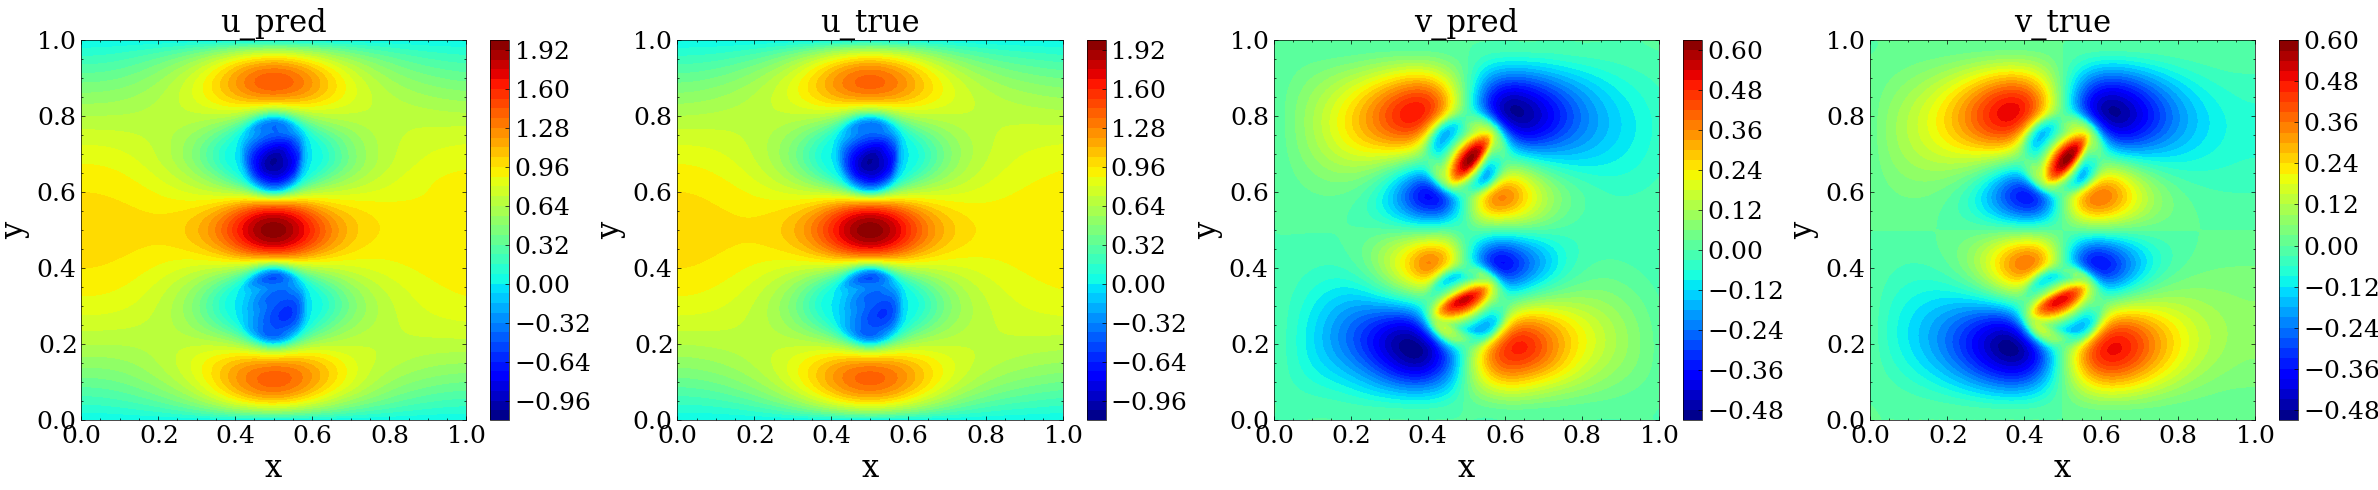

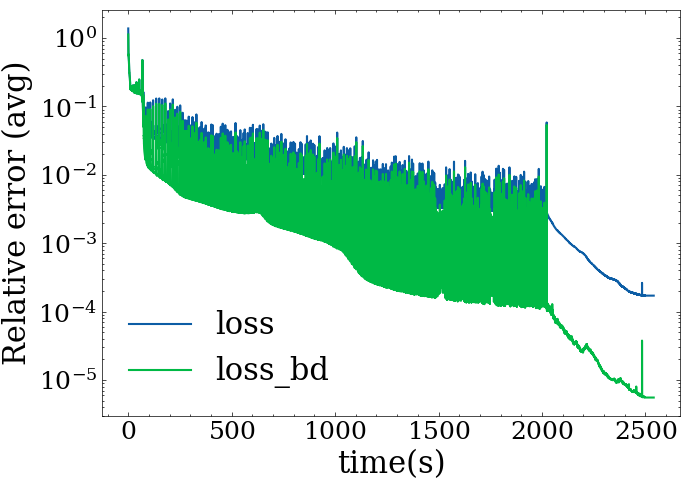

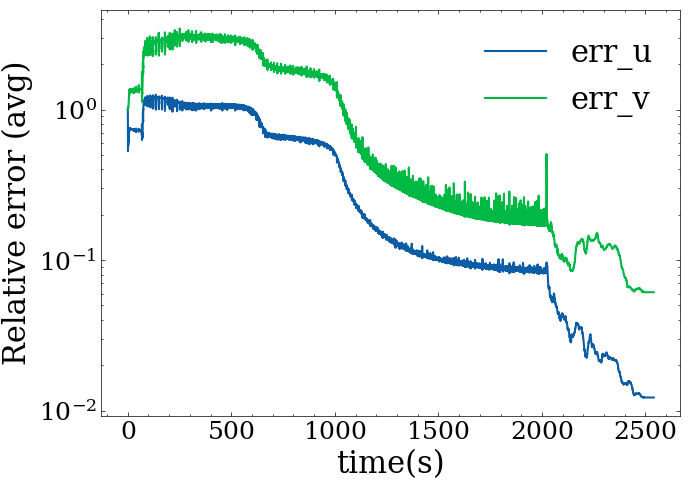

In [3]:
from torch.autograd import Variable
from Utils.PlotFigure import Plot
from Utils.Losses import *
from Solvers.ParticleWNN import ParticleWNN
myerror = MyLoss().lp_rel
# #####################################
# # load trained model
# #####################################
solver = ParticleWNN.Solver(device, dtype=dtype)
model_trained = solver.loadModel(path=f'saved_models/', name='model_particlewnn_final')

###############################
# make prediction
###############################
def get_values(x, solver, model):
    '''
    '''
    psi_p = model(x)
    psi, p = psi_p[...,0:1], psi_p[:,1:2]
    #
    dpsi = solver.grad(psi, [x])[0]
    u, v = dpsi[...,1:2], - dpsi[...,0:1]
    #
    s11, s22, s12 = psi_p[...,2:3], psi_p[...,3:4], psi_p[...,4:5]
    
    return u, v, p, s11, s22, s12
#
x_pred = Variable(x_test.to(device), requires_grad=True)
u_pred, v_pred, p_pred, _, _, _= get_values(x_pred, solver, model_trained['psi_p'])
u_pred = u_pred.detach().cpu()
v_pred = v_pred.detach().cpu()
p_pred = p_pred.detach().cpu()
#
print('The l2 error u is:', myerror(u_pred, u_test))
print('The l2 error v is:', myerror(v_pred, v_test))
######################################################
# show the solution
Plot.show_2d_list(x_test, [u_pred, u_test, v_pred, v_test], ['u_pred', 'u_true', 'v_pred', 'v_true'], ub=[1., 1.])
# show the loss
loss_saved = solver.loadLoss(path=f'saved_models/', name='loss_particlewnn')
Plot.show_error([loss_saved['time']]*2, 
                [loss_saved['loss'],  loss_saved['loss_bd']],['loss', 'loss_bd'])
# show the error
Plot.show_error([loss_saved['time']]*2, [loss_saved['error'][:,0], loss_saved['error'][:,1]], ['err_u', 'err_v'])